## 原理 Principle

使用各类回归模型，选取股票的开始时间和分割点，用过往的历史数据来拟合股票的走势，并用于验证后面的走势

Utilize various regression models to select the stock’s starting time and split points. Use historical data to fit the stock’s price trend and validate it against future price movements.

## 代码 Code

### 数据预览 Data Overview

[*********************100%***********************]  1 of 1 completed


<Axes: xlabel='Date'>

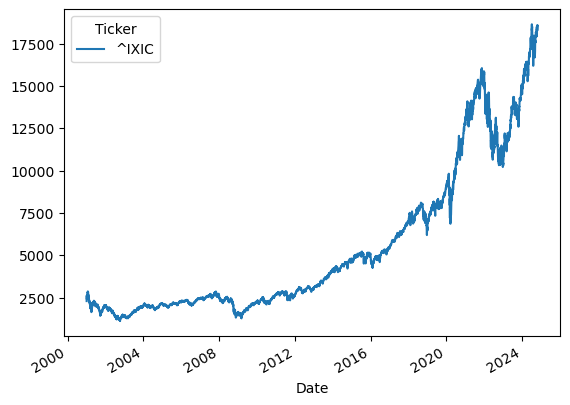

In [1]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# Download historical data for the NASDAQ index
# 下载纳斯达克指数的历史数据
symbol = "^IXIC"
nasdaq = yf.download(symbol, start="2001-01-01")
nasdaq['Close'].plot()

## 尝试不同的模型 Trying Different Models

[*********************100%***********************]  1 of 1 completed


Linear Model - Mean Squared Error: 42941737.59
Logarithmic Model - Mean Squared Error: 83908948.20
Exponential Model - Mean Squared Error: 35277856.61
Polynomial Model - Mean Squared Error: 6447354.39
Power Function Model - Mean Squared Error: 96718895.12


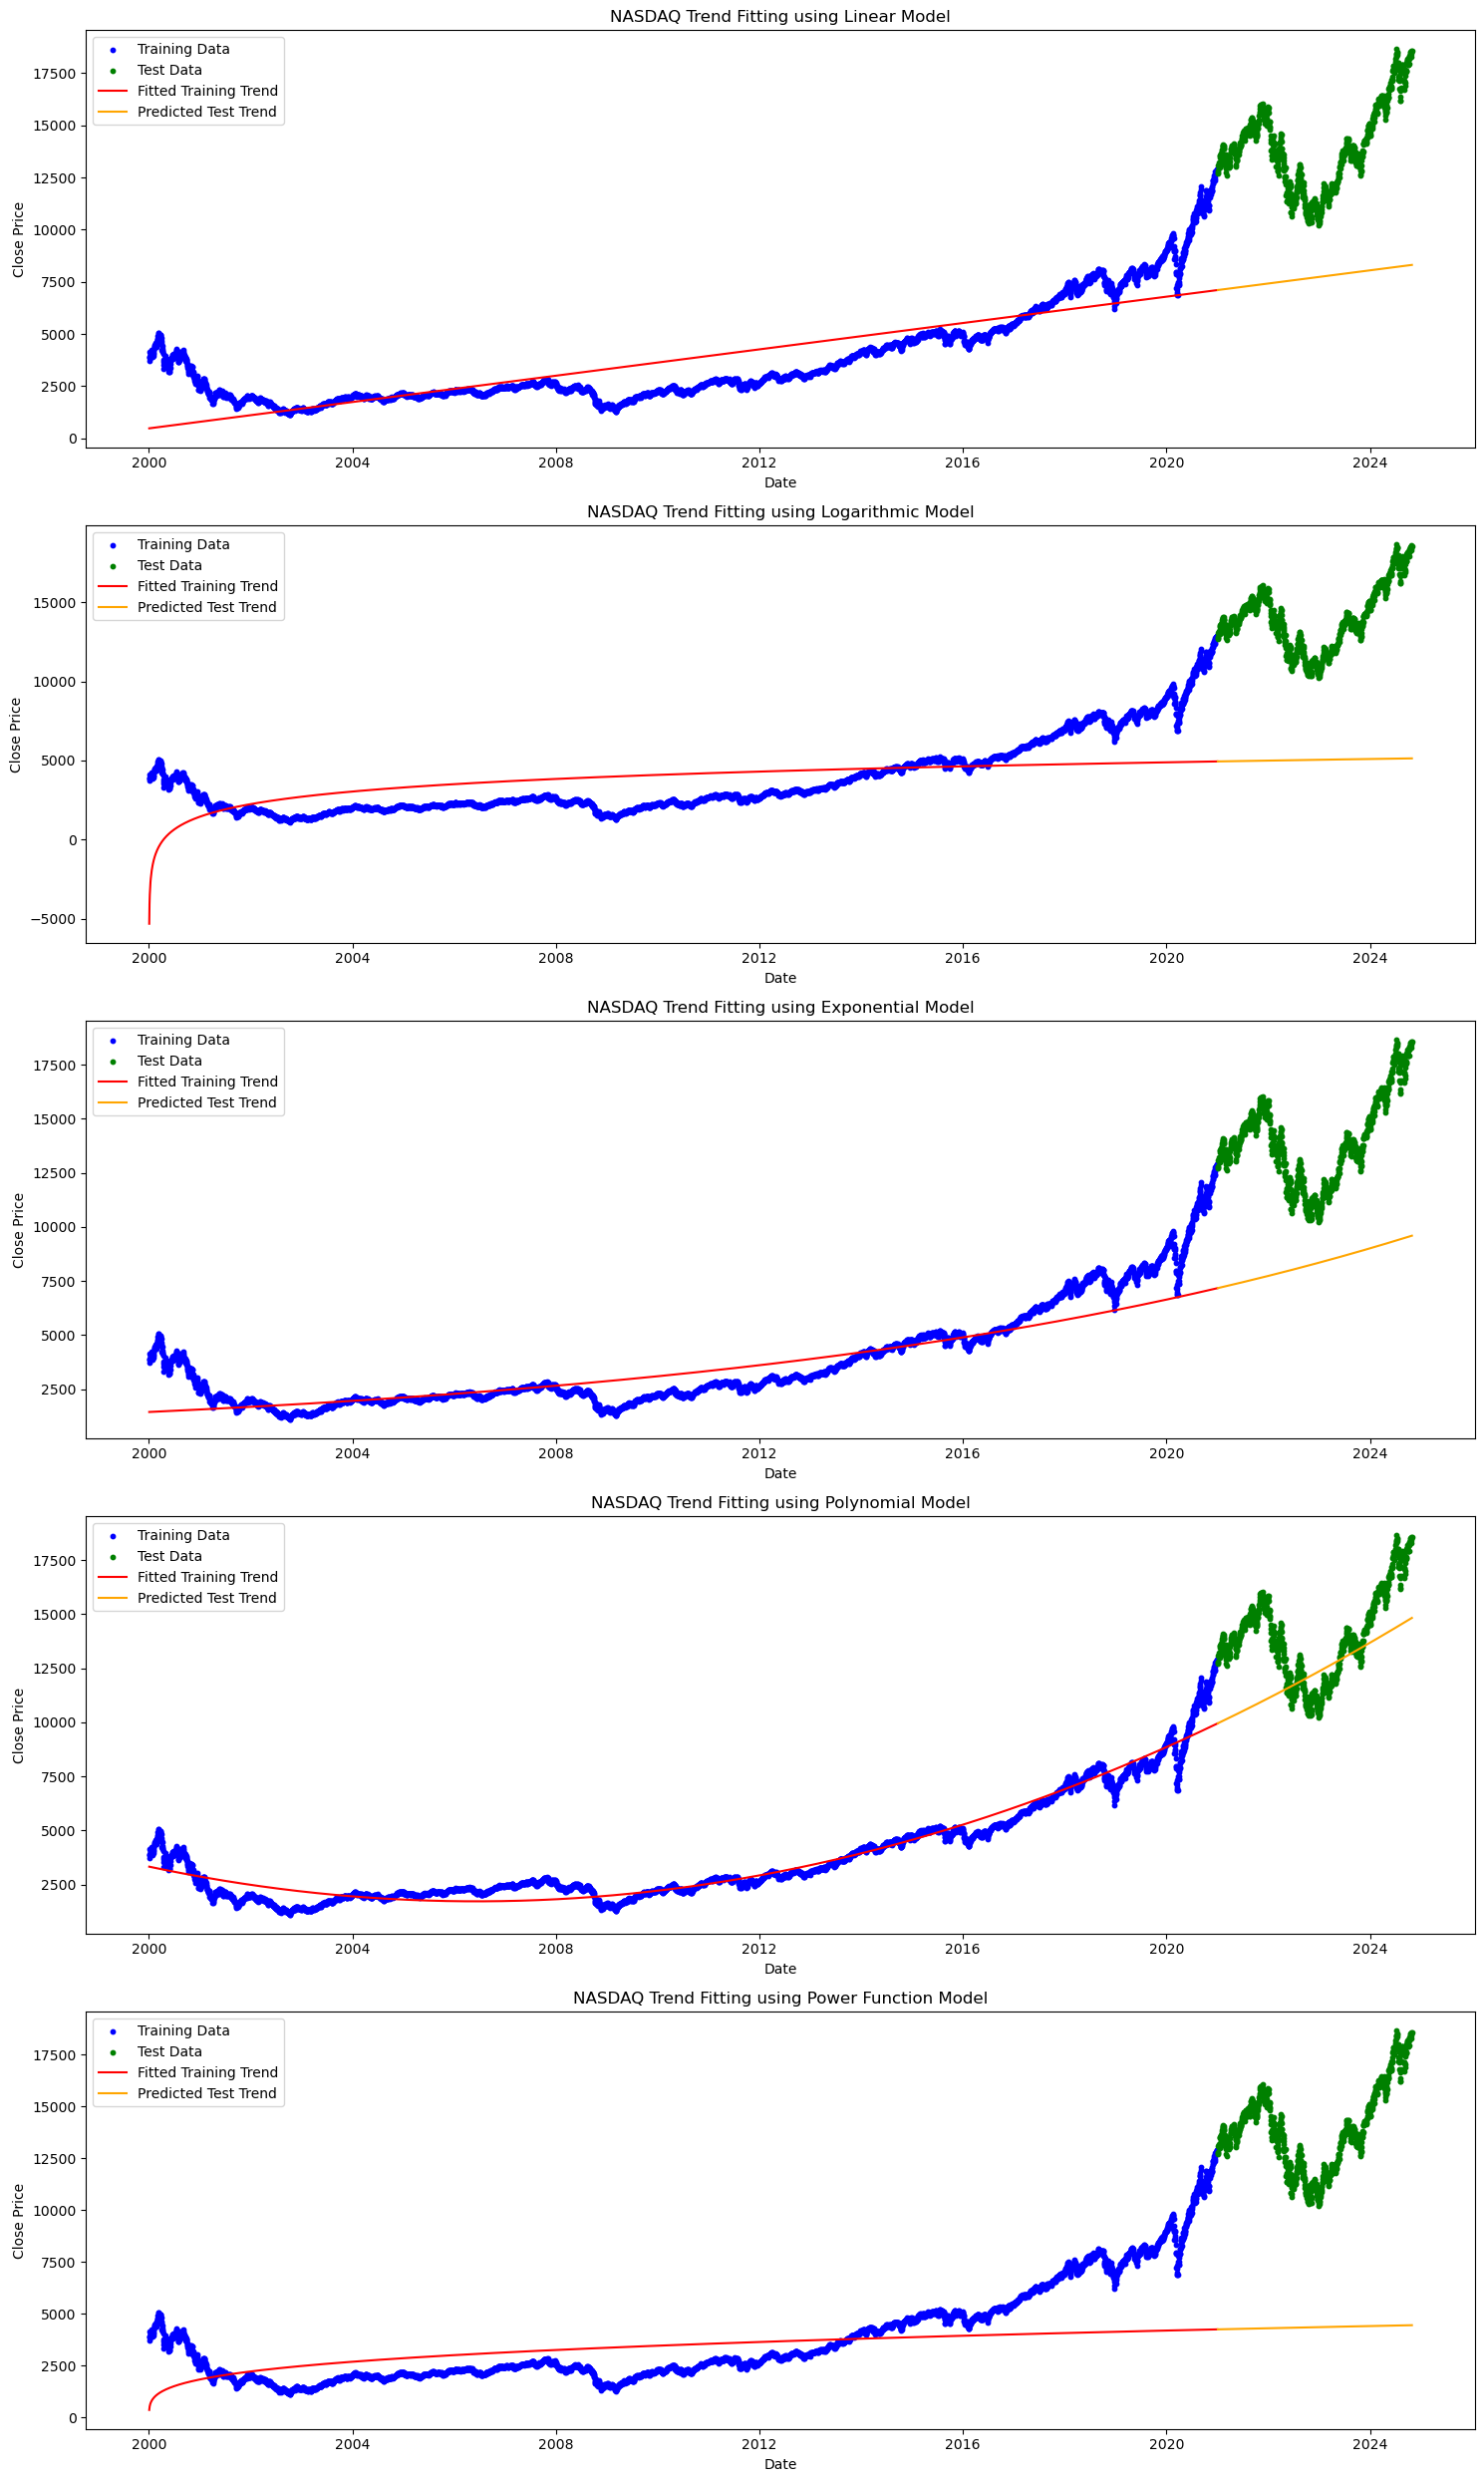

In [10]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error
import warnings

# Suppress warnings for cleaner output
warnings.filterwarnings("ignore")

# 1. Download historical data for the NASDAQ index
symbol = "^IXIC"
nasdaq = yf.download(symbol, start="2000-01-01", end="2025-10-01")

# Ensure the data is sorted by date
nasdaq.sort_index(inplace=True)

# Use closing prices
nasdaq = nasdaq[['Close']]

# 2. Prepare the data
# Create a numerical index for regression (e.g., days since start)
nasdaq.reset_index(inplace=True)
nasdaq['Days'] = (nasdaq['Date'] - nasdaq['Date'].min()).dt.days

# Split into training (up to 2020-12-31) and testing (from 2021-01-01)
train = nasdaq[nasdaq['Date'] <= '2020-12-31']
test = nasdaq[nasdaq['Date'] > '2020-12-31']

X_train = train[['Days']].values  # Shape: (n_samples, 1)
y_train = train['Close'].values
X_test = test[['Days']].values
y_test = test['Close'].values

# Define models with their corresponding transformations
models = {
    'Linear': {'model': LinearRegression(), 'transform': 'none'},
    'Logarithmic': {'model': LinearRegression(), 'transform': 'log'},
    'Exponential': {'model': LinearRegression(), 'transform': 'exp'},
    'Polynomial': {'model': LinearRegression(), 'transform': 'poly', 'degree': 2},
    'Power Function': {'model': LinearRegression(), 'transform': 'power'}
}

# Prepare plots
plt.figure(figsize=(15, 25))
plt.subplots_adjust(hspace=0.5)
plot_num = 1

# Store results
results = {}

for name, params in models.items():
    # Initialize variables to avoid reference before assignment
    X_tr = X_train.copy()
    X_te = X_test.copy()
    y_tr = y_train.copy()
    
    # Prepare features based on transformation
    if params['transform'] == 'none':
        pass  # No transformation
    elif params['transform'] == 'log':
        X_tr = np.log(X_train + 1)  # Adding 1 to avoid log(0)
        X_te = np.log(X_test + 1)
    elif params['transform'] == 'exp':
        # For exponential, we model log(y) = a * x + b
        y_tr = np.log(y_train)
    elif params['transform'] == 'poly':
        degree = params.get('degree', 2)
        poly = PolynomialFeatures(degree)
        X_tr = poly.fit_transform(X_train)
        X_te = poly.transform(X_test)
    elif params['transform'] == 'power':
        # For power function, we model log(y) = a * log(x) + b
        # To avoid log(0), add 1 to Days
        X_tr = np.log(X_train + 1)
        X_te = np.log(X_test + 1)
        y_tr = np.log(y_train)
    else:
        raise ValueError("Unknown transformation")

    # Initialize model
    model = params['model']
    
    # Fit the model
    model.fit(X_tr, y_tr if params['transform'] in ['exp', 'power'] else y_train)
    
    # Make predictions
    if params['transform'] == 'exp':
        y_pred_train = np.exp(model.predict(X_tr))
        y_pred_test = np.exp(model.predict(X_te))
    elif params['transform'] == 'power':
        y_pred_train = np.exp(model.predict(X_tr))
        y_pred_test = np.exp(model.predict(X_te))
    else:
        y_pred_train = model.predict(X_tr)
        y_pred_test = model.predict(X_te)
    
    # Calculate Mean Squared Error
    mse = mean_squared_error(y_test, y_pred_test)
    results[name] = mse

    # Plotting
    plt.subplot(len(models), 1, plot_num)
    plot_num += 1
    plt.scatter(train['Date'], y_train, label='Training Data', color='blue', s=10)
    plt.scatter(test['Date'], y_test, label='Test Data', color='green', s=10)
    plt.plot(train['Date'], y_pred_train, label='Fitted Training Trend', color='red')
    plt.plot(test['Date'], y_pred_test, label='Predicted Test Trend', color='orange')
    plt.title(f'NASDAQ Trend Fitting using {name} Model')
    plt.xlabel('Date')
    plt.ylabel('Close Price')
    plt.legend()

# Display evaluation metrics
for name, mse in results.items():
    print(f'{name} Model - Mean Squared Error: {mse:.2f}')

plt.tight_layout()
plt.show()

## 多项式回归拟合

In [6]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error

def plot_nasdaq_polynomial_fit(train_start_date, split_date, ax=None, symbol="^IXIC", degrees=[3,4,5]):
    """
    使用多项式回归拟合纳斯达克指数，并绘制训练集和测试集的实际值及预测值。
    Perform polynomial regression on the NASDAQ index and plot actual and predicted values for training and testing sets.
    
    参数:
    - train_start_date (str): 训练数据的起始日期，例如 "2000-01-01"
                              Start date for training data, e.g., "2000-01-01"
    - split_date (str): 训练集与测试集的划分日期，训练集为小于该日期的数据，测试集为大于等于该日期的数据，例如 "2021-01-01"
                        Split date between training and testing sets. Training set includes data before this date, and testing set includes data on or after this date, e.g., "2021-01-01"
    - ax (matplotlib.axes.Axes, optional): 用于绘图的Axes对象。如果为None，则创建新的Figure。
                                           Matplotlib Axes object for plotting. If None, a new Figure is created.
    - symbol (str): 股票或指数的代码，默认是纳斯达克指数 "^IXIC"
                    Stock or index symbol, default is NASDAQ index "^IXIC"
    - degrees (list): 要使用的多项式阶数，默认是 [3, 4, 5]
                      List of polynomial degrees to use, default is [3, 4, 5]
    """
    
    # 下载指定时间范围内的历史数据
    # Download historical data for the specified time range
    nasdaq = yf.download(symbol, start=train_start_date)
    nasdaq['Date'] = nasdaq.index

    # 划分训练集和测试集
    # Split data into training and testing sets
    train_data = nasdaq[nasdaq['Date'] < split_date]
    test_data = nasdaq[nasdaq['Date'] >= split_date]

    # 检查是否有足够的数据进行训练和测试
    # Check if there is enough data for training and testing
    if train_data.empty:
        raise ValueError(f"Training data is empty for split_date='{split_date}'. Please check the training start date and split date.")
    if test_data.empty:
        raise ValueError(f"Testing data is empty for split_date='{split_date}'. Please check the split date.")
    
    # 准备训练和测试数据
    # Prepare training and testing data
    X_train = np.array((train_data.index - train_data.index[0]).days).reshape(-1, 1)
    y_train = train_data['Close'].values
    X_test = np.array((test_data.index - train_data.index[0]).days).reshape(-1, 1)
    y_test = test_data['Close'].values

    # 如果未提供Axes对象，则创建新的绘图窗口
    # If no Axes object is provided, create a new plotting window
    if ax is None:
        fig, ax = plt.subplots(figsize=(14, 8))
    
    # 绘制训练集的实际数据
    # Plot actual training data
    ax.plot(train_data['Date'], train_data['Close'], label='Actual Data (Train)', color='black', alpha=0.7)
    
    # 绘制划分日期的垂直线
    # Draw a vertical line for the split date
    ax.axvline(pd.to_datetime(split_date), color='black', label='Split Date')
    
    # 绘制测试集的实际数据
    # Plot actual testing data
    ax.plot(test_data['Date'], test_data['Close'], label='Actual Data (Test)', color='blue', alpha=0.7)

    # 定义颜色列表用于不同阶数的多项式
    # Define a color list for different polynomial degrees
    colors = ['red', 'green', 'orange', 'purple', 'brown']

    # 遍历每个指定的多项式阶数进行拟合
    # Iterate through each specified polynomial degree for fitting
    for i, degree in enumerate(degrees):
        if i >= len(colors):
            color = np.random.rand(3,)  # 随机颜色
            # Random color if colors list is exhausted
        else:
            color = colors[i]
        
        # 生成多项式特征
        # Generate polynomial features
        poly = PolynomialFeatures(degree=degree)
        X_poly_train = poly.fit_transform(X_train)
        X_poly_test = poly.transform(X_test)

        # 拟合线性回归模型
        # Fit the linear regression model
        poly_model = LinearRegression()
        poly_model.fit(X_poly_train, y_train)

        # 进行预测
        # Make predictions
        y_poly_train_pred = poly_model.predict(X_poly_train)
        y_poly_test_pred = poly_model.predict(X_poly_test)

        # 绘制训练集的预测结果
        # Plot training set predictions
        ax.plot(train_data['Date'], y_poly_train_pred, label=f'Poly (deg={degree}, Train)', color=color)
        
        # 绘制测试集的预测结果（使用虚线区分）
        # Plot testing set predictions (dashed line)
        ax.plot(test_data['Date'], y_poly_test_pred, label=f'Poly (deg={degree}, Test)', color=color, linestyle='--')

    # 设置图表标题和坐标轴标签（仅在单个子图中设置标题）
    # Set chart title and axis labels (only for the first subplot)
    if ax is not None:
        ax.set_title(f"NASDAQ Index Trend Fitting and Prediction\nSplit Date: {split_date}")
        ax.set_xlabel("Date")
        ax.set_ylabel("Closing Price")
        ax.legend(loc="upper left", fontsize='small')
        ax.grid(True)

def plot_multiple_nasdaq_polynomial_fits(train_start_date, split_dates, symbol="^IXIC", degrees=[3,4,5], cols=2):
    """
    创建多个子图，每个子图对应一个不同的划分日期，展示纳斯达克指数的多项式拟合结果。
    Create multiple subplots, each corresponding to a different split date, showing the polynomial fit results for the NASDAQ index.
    
    参数:
    - train_start_date (str): 训练数据的起始日期，例如 "2000-01-01"
                              Start date for training data, e.g., "2000-01-01"
    - split_dates (list): 包含多个划分日期的列表，例如 ["2020-01-01", "2021-01-01"]
                           List of split dates, e.g., ["2020-01-01", "2021-01-01"]
    - symbol (str): 股票或指数的代码，默认是纳斯达克指数 "^IXIC"
                    Stock or index symbol, default is NASDAQ index "^IXIC"
    - degrees (list): 要使用的多项式阶数，默认是 [3, 4, 5]
                      List of polynomial degrees to use, default is [3, 4, 5]
    - cols (int): 每行的子图数量，默认是2
                  Number of subplots per row, default is 2
    """
    import math
    num_plots = len(split_dates)
    rows = math.ceil(num_plots / cols)
    
    # 创建子图网格
    # Create a grid of subplots
    fig, axes = plt.subplots(rows, cols, figsize=(14, 6 * rows), squeeze=False)
    fig.suptitle("NASDAQ Index Polynomial Regression Fits", fontsize=16)

    # 遍历每个split_date并绘制相应的子图
    # Iterate through each split_date and plot the corresponding subplot
    for idx, split_date in enumerate(split_dates):
        row = idx // cols
        col = idx % cols
        ax = axes[row][col]
        try:
            plot_nasdaq_polynomial_fit(train_start_date, split_date, ax=ax, symbol=symbol, degrees=degrees)
        except ValueError as e:
            ax.text(0.5, 0.5, str(e), horizontalalignment='center', verticalalignment='center', fontsize=12, color='red')
            ax.set_title(f"Failed to plot for split date {split_date}")
            ax.axis('off')
    
    # 如果子图数量不是网格的整数倍，隐藏多余的子图
    # Hide any unused subplots
    total = rows * cols
    if num_plots < total:
        for idx in range(num_plots, total):
            row = idx // cols
            col = idx % cols
            axes[row][col].axis('off')
    
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust layout to make room for the suptitle
    plt.show()

    # 计算并打印各阶数多项式回归的均方误差 (MSE) 对于每个split_date
    # Calculate and print Mean Squared Error (MSE) for each polynomial degree for each split_date
    print("\nMean Squared Error (MSE) for Polynomial Regression on Test Sets:")
    for split_date in split_dates:
        try:
            nasdaq = yf.download(symbol, start=train_start_date)
            nasdaq['Date'] = nasdaq.index
            train_data = nasdaq[nasdaq['Date'] < split_date]
            test_data = nasdaq[nasdaq['Date'] >= split_date]
            if train_data.empty or test_data.empty:
                print(f"\nSplit Date: {split_date}")
                print("Insufficient data for training or testing.")
                continue
            
            X_train = np.array((train_data.index - train_data.index[0]).days).reshape(-1, 1)
            y_train = train_data['Close'].values
            X_test = np.array((test_data.index - train_data.index[0]).days).reshape(-1, 1)
            y_test = test_data['Close'].values

            for degree in degrees:
                poly = PolynomialFeatures(degree=degree)
                X_poly_train = poly.fit_transform(X_train)
                X_poly_test = poly.transform(X_test)

                poly_model = LinearRegression()
                poly_model.fit(X_poly_train, y_train)

                y_poly_test_pred = poly_model.predict(X_poly_test)
                mse_poly = mean_squared_error(y_test, y_poly_test_pred)
        except Exception as e:
            print(f"\nSplit Date: {split_date}")
            print(f"Error calculating MSE: {e}")

### 多项式回归拟合-不同分割点的预测 Polynomial Regression Fitting - Predictions with Different Split Points

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


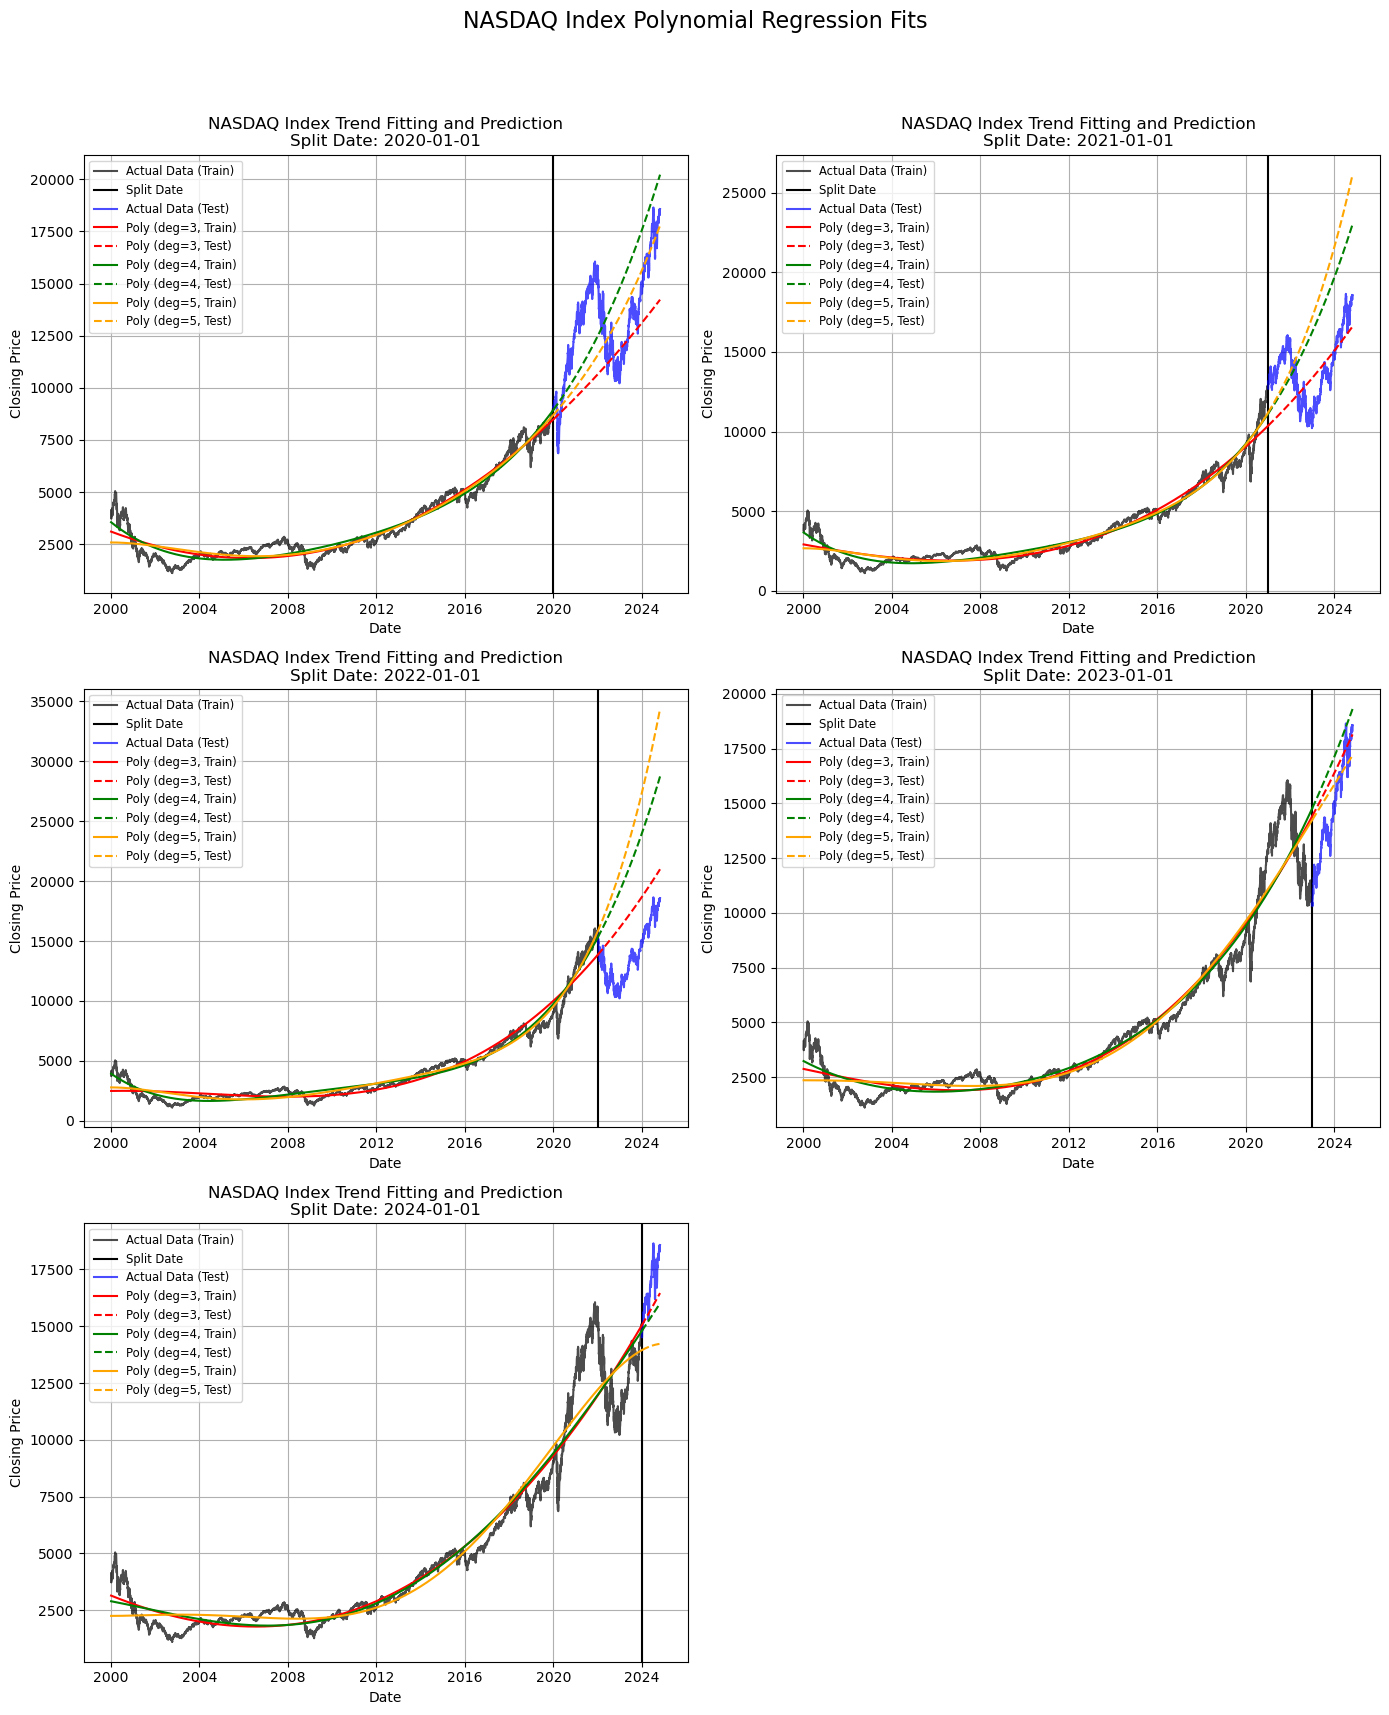


Mean Squared Error (MSE) for Polynomial Regression on Test Sets:


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [7]:
# 设置训练起始日期和多个划分日期
# Set training start date and multiple split dates
train_start = "2000-01-01"
split_dates = [
    "2020-01-01",
    "2021-01-01",
    "2022-01-01",
    "2023-01-01",
    "2024-01-01"  # Note: Data for this date may not be available depending on the current date
]

# 调用函数进行绘图和拟合
# Call the function to plot and fit
plot_multiple_nasdaq_polynomial_fits(train_start_date=train_start, split_dates=split_dates)

## 多项式回归拟合-不同时间范围的预测 Polynomial Regression Fitting - Predictions with Different Time Ranges

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


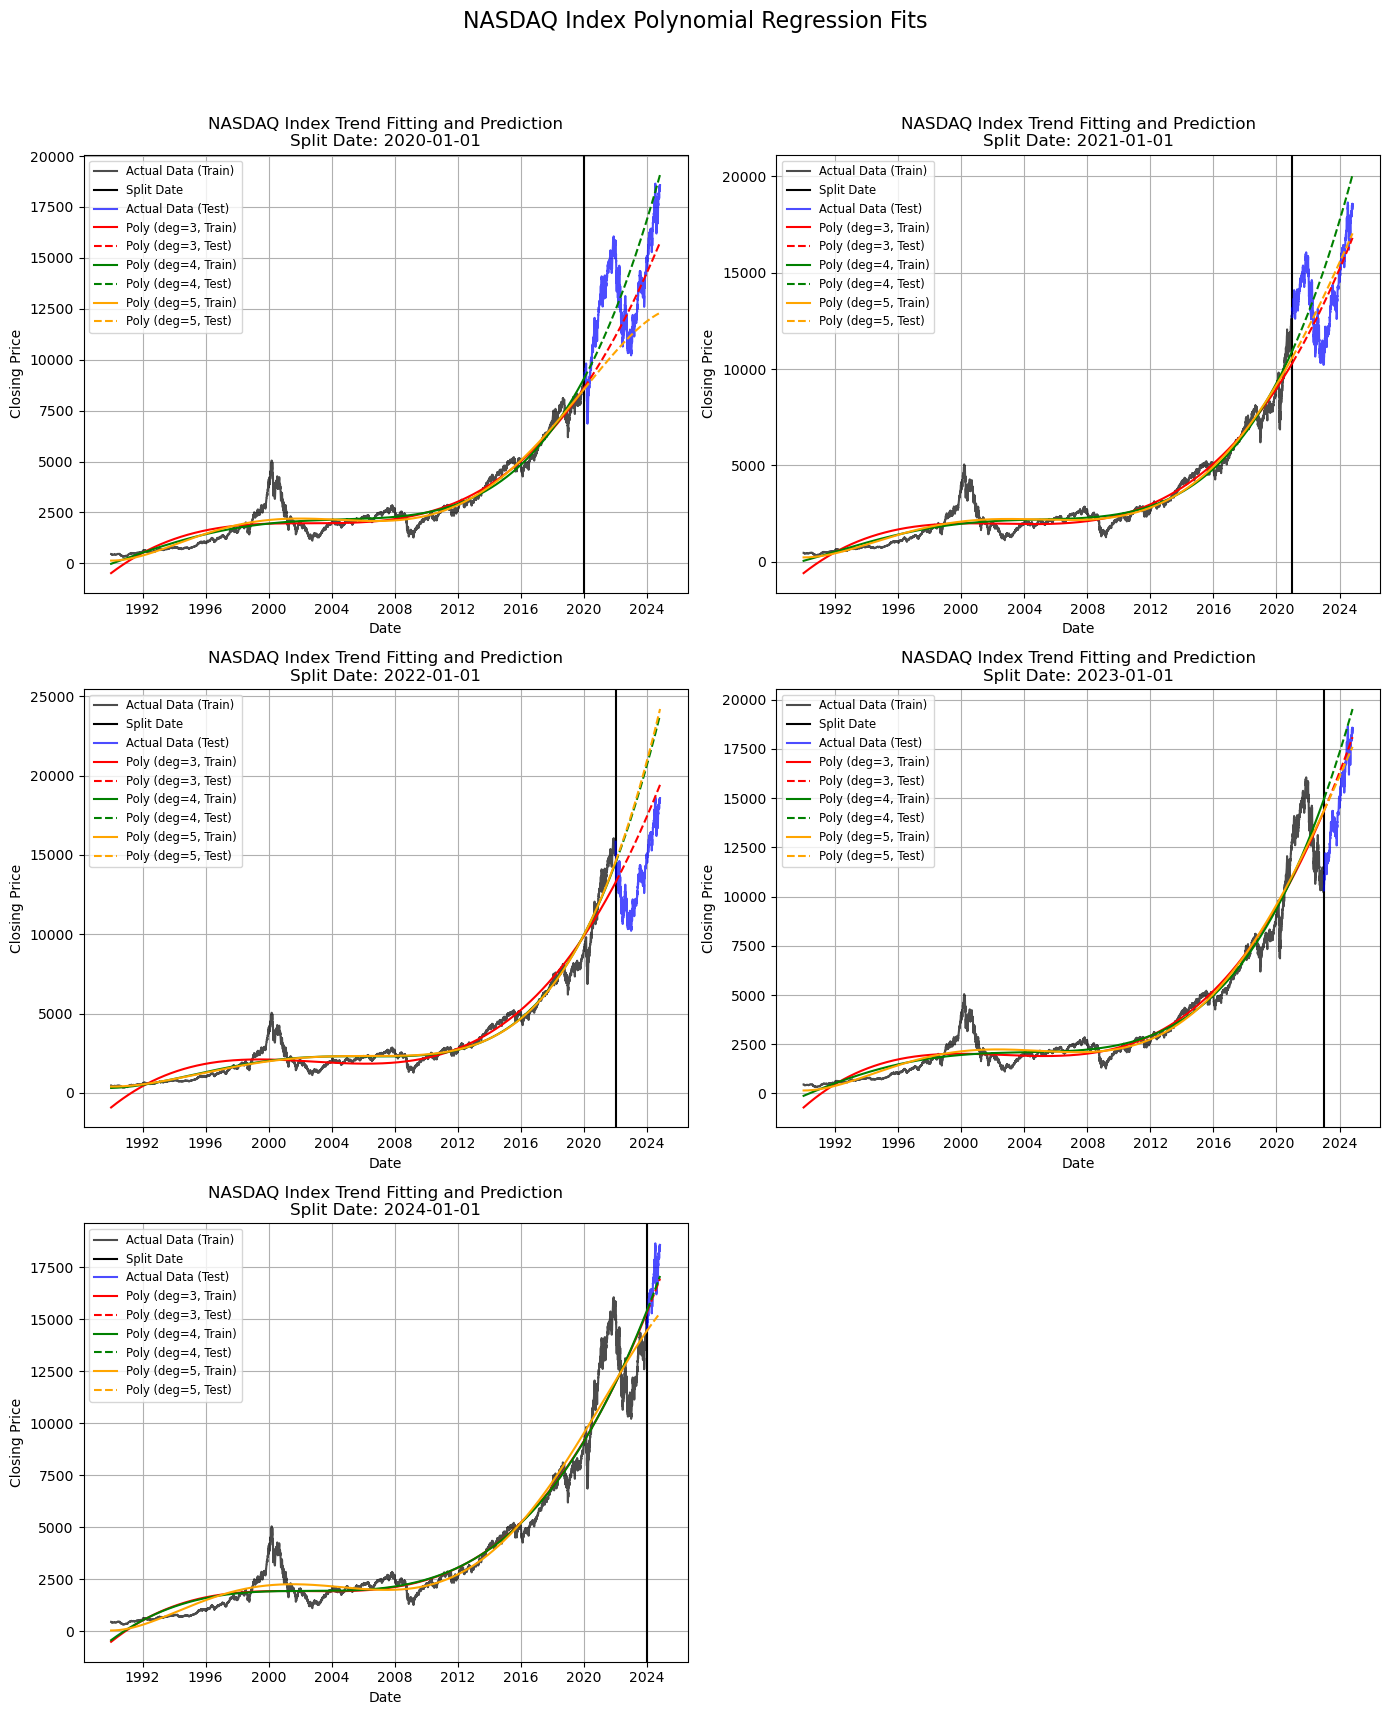


Mean Squared Error (MSE) for Polynomial Regression on Test Sets:


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [8]:
# 设置训练起始日期和多个划分日期
# Set training start date and multiple split dates
train_start = "1990-01-01"
split_dates = [
    "2020-01-01",
    "2021-01-01",
    "2022-01-01",
    "2023-01-01",
    "2024-01-01"  # Note: Data for this date may not be available depending on the current date
]

# 调用函数进行绘图和拟合
# Call the function to plot and fit
plot_multiple_nasdaq_polynomial_fits(train_start_date=train_start, split_dates=split_dates)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


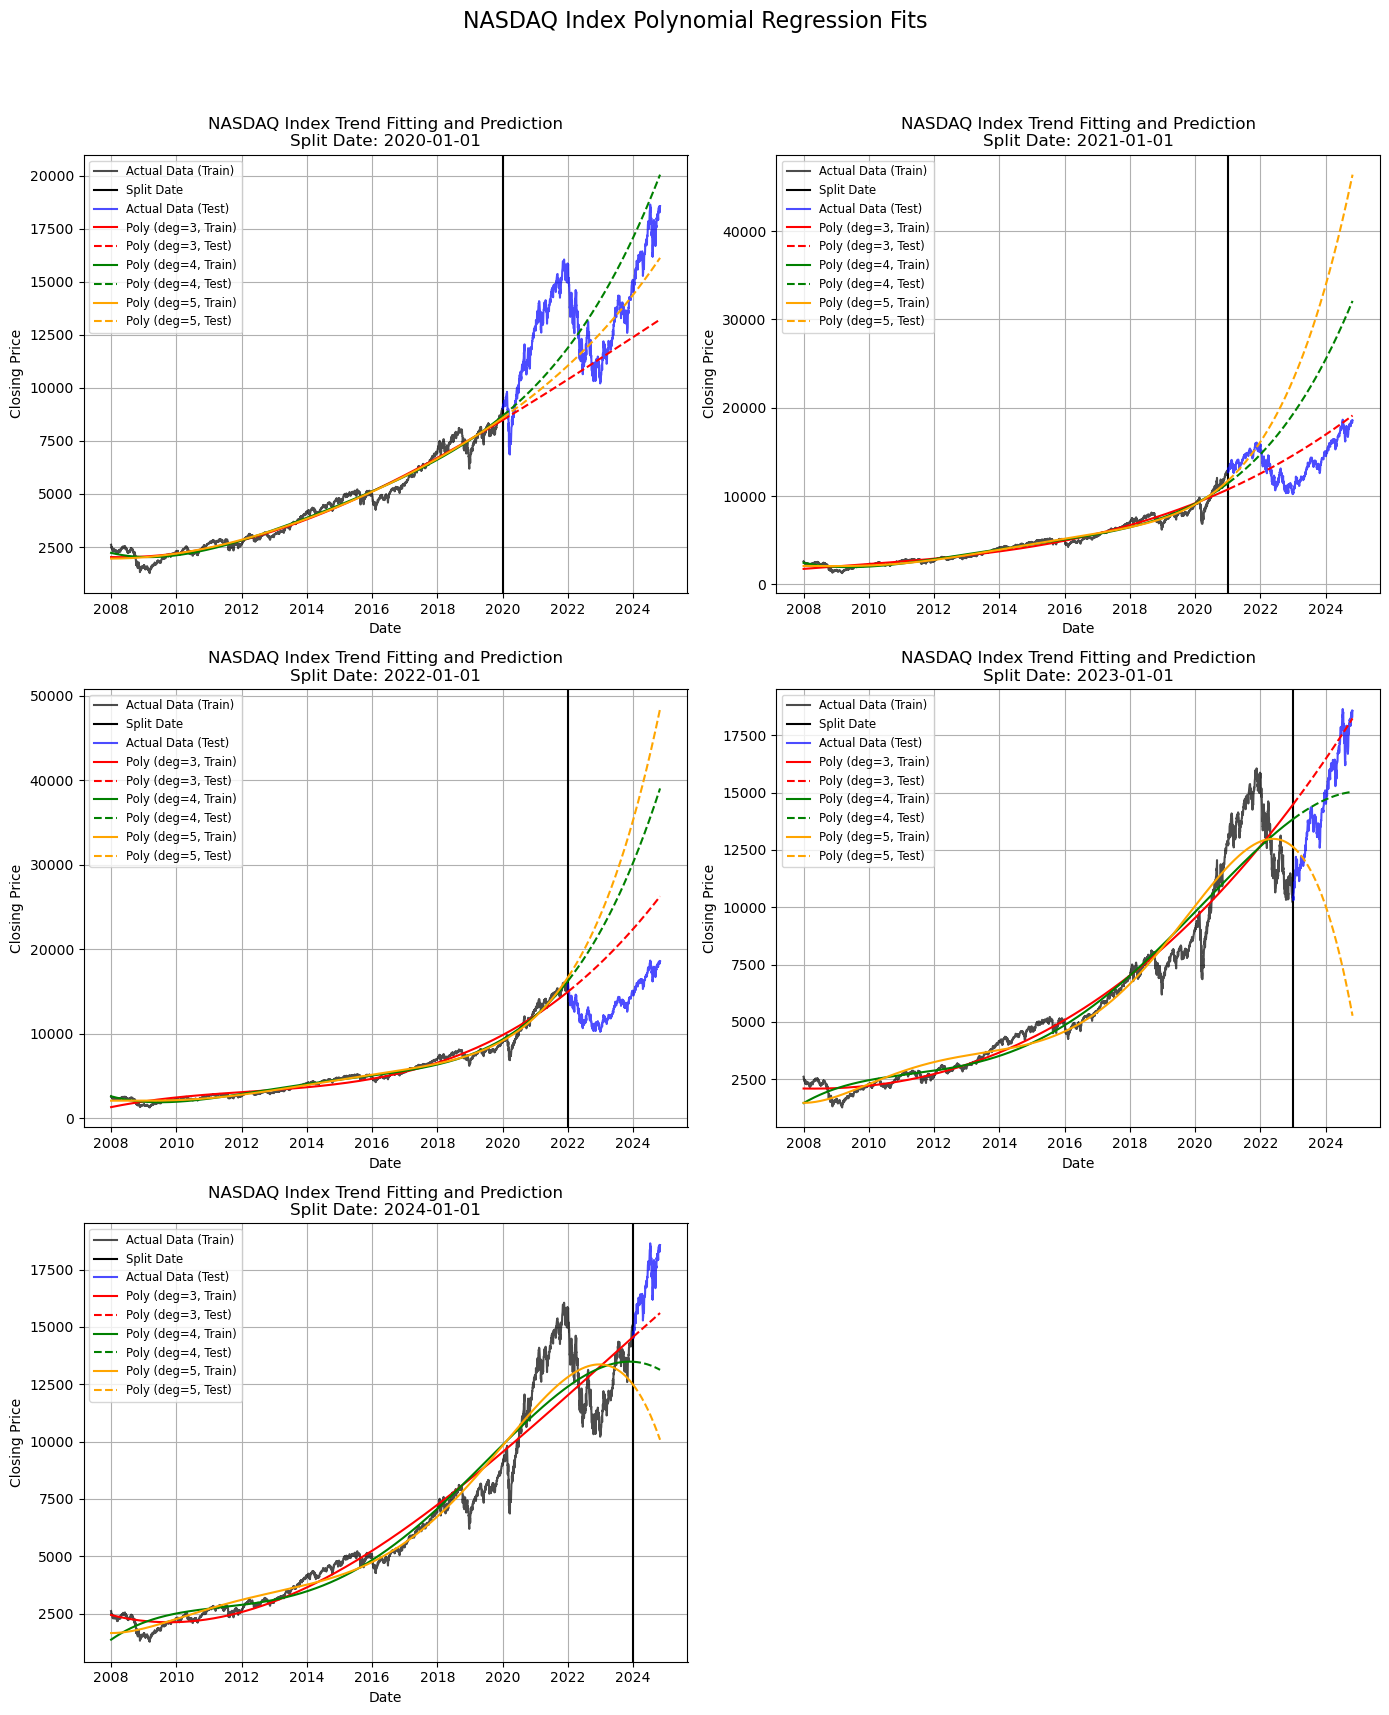


Mean Squared Error (MSE) for Polynomial Regression on Test Sets:


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [9]:
# 设置训练起始日期和多个划分日期
# Set training start date and multiple split dates
train_start = "2008-01-01"
split_dates = [
    "2020-01-01",
    "2021-01-01",
    "2022-01-01",
    "2023-01-01",
    "2024-01-01"  # Note: Data for this date may not be available depending on the current date
]

# 调用函数进行绘图和拟合
# Call the function to plot and fit
plot_multiple_nasdaq_polynomial_fits(train_start_date=train_start, split_dates=split_dates)